# Laboratorium

### Konfiguracja

In [48]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js


# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [24]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        plt.axis('square')
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
    ### Kod kradziony przyznaję się bez bicia
    def save(self, scene_index, path='.'):
        plt.close()
        ax = plt.axes()
        plt.axis('square')
        scene = self.scenes[scene_index]
        for collection in scene.points:
            if len(collection.points) > 0:
                ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (scene.lines):
            ax.add_collection(collection.get_collection())
        ax.autoscale(True)
        plt.savefig(path+"/figure_"+str(scene_index)+".png")
        

# Rozwiązanie

### Przydatne funkcjie

In [25]:
import functools

# odległość między punktami a i b
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

# wyznacznik
def det(a,b,c): # > 0 gdy c jest po lewej stronie ab
    tab = np.array([[a[0]-c[0], a[1]-c[1]],[b[0]-c[0], b[1]-c[1]]])
    return np.linalg.det(tab)

# funkcja znajdująca element o najmniejszej współżędnej y (następnie x) w zbiorze T
def lowest(T):
    min_now = 0
    for i in range(len(T)):
        if T[i][1] < T[min_now][1]:
            min_now = i
        elif T[i][1] == T[min_now][1]:
            if T[i][0] < T[min_now][0]:
                min_now = i
    return min_now

# porównanie kąta. jeśli a jest po lewej stronie odcina (center,b) to ustalamy, że kąt dla a jest większy
def angle_compare(a, b, center, e):
    det_val = det(a,b,center)
    if det_val > e:
        return -1
    elif det_val < -1*e:
        return 1
    else:
        return 0

    

# sortorwanie wbudowane używające porównywania kątów. Punkty współliniowe usuwane po posortowaniu wszystkich punktów 
def axis_sort(T, center_index, e):
    center = T[center_index]
    T = T[:center_index] + T[center_index+1:]
    
    #sortowanie z użyciem porównania kątów 
    A = sorted(T, key=functools.cmp_to_key(lambda a, b: angle_compare(a,b,center,e)) ) #
    
    #inicjalizacja wyniku
    result = [center]
    
    #usuwanie punktów współliniowych
    n = len(A)
    i = 0
    while i < n:
        now = A[i]
        while i < n-1 and det(result[0],A[i],A[i+1]) < e and det(result[0],A[i],A[i+1]) > -1*e:
            if dist(now,center) < dist(A[i+1],center) and A[i+1] != center:
                now = A[i+1]
            i+=1
        result.append(now)
        i+=1
    return result  




# własna implementacja algorytmu mergesort do sortowania kątów. Punkty współliniowe usuwane w trakcie działania algorytmu
def axis_mergesort(points,center_index,e):
    center = points[center_index]
    T = points[:center_index]+points[center_index+1:]
    def rec(A):
        if len(A) > 1:
            n = len(A)
            m = n//2
            left = A[:m]
            right = A[m:]
            left = rec(left)
            right = rec(right)
            i,j = 0,0
            result = []
            while i < len(left) or j < len(right):
                if i < len(left) and (j == len(right) or angle_compare(left[i], right[j],center,e)==-1):
                    if len(result) > 0 and angle_compare(result[-1],left[i],center,e) == 0:
                        if dist(center,left[i])>dist(center,result[-1]):
                            result[-1] = left[i]
                        else:
                            None
                    else:
                        result.append(left[i])
                    i+=1
                else:
                    if len(result) > 0 and angle_compare(result[-1],right[j],center,e) == 0:
                        if dist(center,right[j])>dist(center,result[-1]):
                            result[-1] = right[j]
                        else:
                            None
                    else:
                        result.append(right[j])
                    j+=1
            return result
        else:
            return A
        
    return [center]+rec(T)

In [26]:
%matplotlib notebook

# losowe n punktów leżących między zadanymi prostymi x=left, x = right, y = down, y = up 
def generate_1(low = -100,high = 100,left = -100,right = 100, n = 100):
    return [(np.random.uniform(left,right),np.random.uniform(low, high)) for i in range(n)]

#losowe n punktów na okręgu o promieniu r i o środku w (a,b)
from math import sin, cos, pi
def generate_2(a = 0, b = 0, r = 10, n = 100):
    result = [None]*n
    for i in range(len(result)):
        x = np.random.uniform(0,1)
        result[i] = (a+r*sin(x*2*pi),b+r*cos(x*2*pi))
    return result

#losowe n punktów leżące na bokach czworokąta o kolejnych wierzchołkach dl,dr,ur,ul
# punkty generowane na boku o długości a z prawdopodobieństwem równym a/l gidze l jest długością obwodu
def generate_3(dl=(-10,-10),dr=(10,-10),ur=(10,10),ul=(-10,10), n = 100):
    length_d = dist(dl,dr)
    length_u = dist(ul,ur)
    length_l = dist(dl,ul)
    length_r = dist(dr,ur)
    vector_d = (dr[0]-dl[0],dr[1]-dl[1])
    vector_l = (ul[0]-dl[0],ul[1]-dl[1])
    vector_u = (ur[0]-ul[0],ur[1]-ul[1])
    vector_r = (ur[0]-dr[0],ur[1]-dr[1])
    sum_dist = length_d + length_u + length_l + length_r 
    result = [None]*n
    for i in range(n):
        gen = np.random.random()*sum_dist
        r = np.random.random()
        if gen >= 0 and gen < length_d:
            
            result[i] = (dl[0] + vector_d[0]*r, dl[1] + vector_d[1]*r)
        elif gen >= length_d and gen < length_d+length_l:
            
            result[i] = (dl[0] + vector_l[0]*r, dl[1] + vector_l[1]*r)
        elif gen >= length_d + length_l and gen < length_d + length_l + length_u:
            
            result[i] = ((ul[0] + vector_u[0]*r, ul[1] + vector_u[1]*r))
        else:
            
            result[i] = (dr[0] + vector_r[0]*r, dr[1] + vector_r[1]*r)
    return result

# punkty generowane na osiach układu współżędnych o zadanej współżędnej w przedziale od 0 do a
# dodatkowo punkty wygenerowane na przekątnych kwadratu o wierzchołkach (0,0),(a,0),(a,a),(0,a) oraz te wierzchołki
def generate_4(a = 10, onaxis = 25, ondiagonal = 20):
    result = [None]*(4+2*onaxis+2*ondiagonal)
    result[-4] = (0,a)
    result[-3] = (a,0)
    result[-2] = (a,a)
    result[-1] = (0,0)

    for i in range(onaxis):
        result[i] = (0,np.random.uniform(0, a))
    for i in range(onaxis,2*onaxis):
        result[i] = (np.random.uniform(0, a),0)  
    for i in range(2*onaxis,2*onaxis+ondiagonal):
        r = np.random.uniform(0, a)
        result[i] = (r,r)
    for i in range(2*onaxis+ondiagonal,2*onaxis+2*ondiagonal):
        r = np.random.uniform(0, a)
        result[i] = (r,a-r)
    return result

<IPython.core.display.Javascript object>


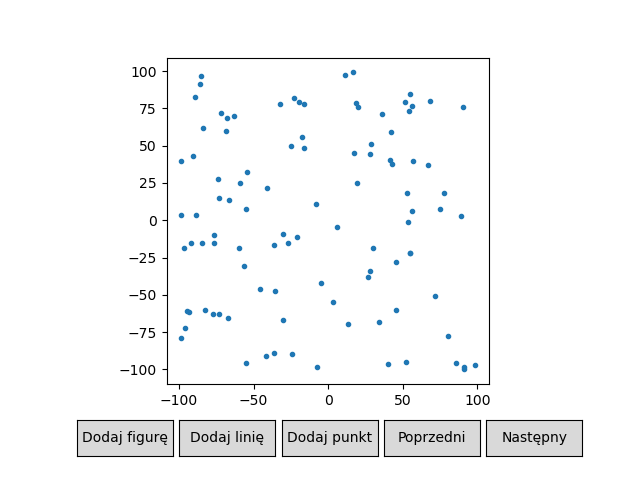

In [27]:
tab1 = generate_1()
plot = Plot(points = [PointsCollection(tab1,marker = ".")])
plot.draw()

<IPython.core.display.Javascript object>


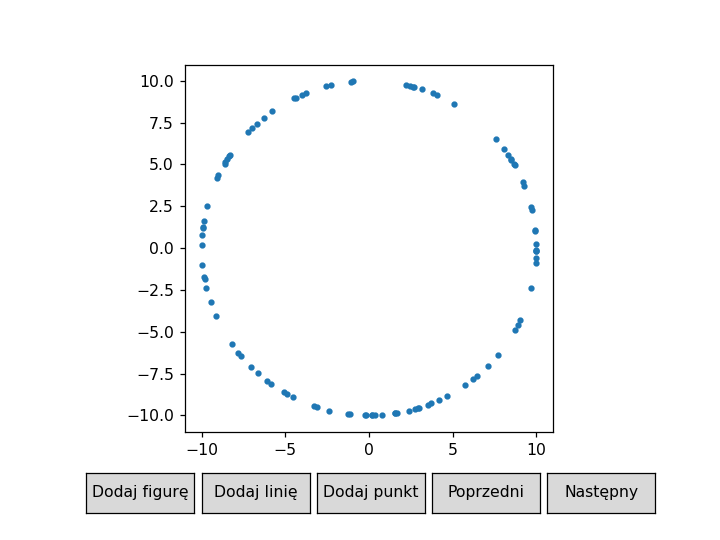

In [44]:
tab2 = generate_2()
plot = Plot(points = [PointsCollection(tab2,marker = ".")])
plot.draw()

<IPython.core.display.Javascript object>


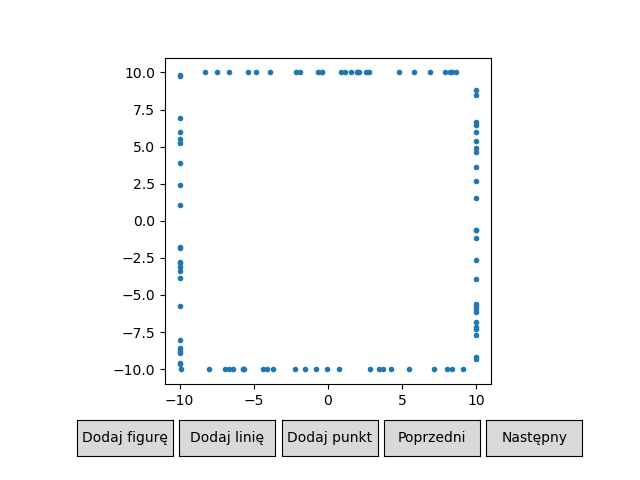

In [29]:
tab3 = generate_3()
plot = Plot(points = [PointsCollection(tab3,marker = ".")])
plot.draw()

<IPython.core.display.Javascript object>


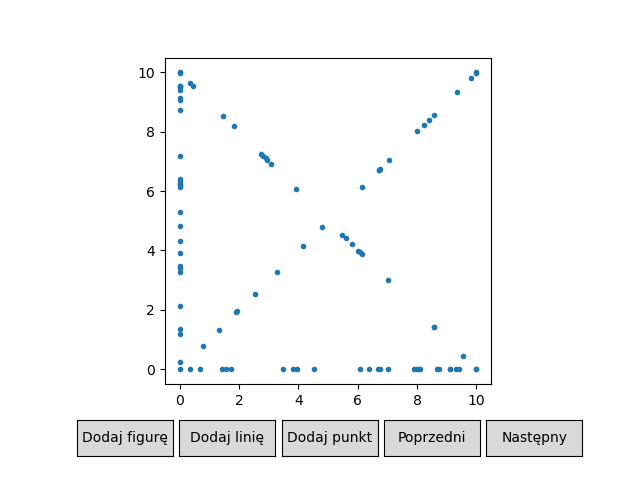

In [30]:
tab4 = generate_4()
plot = Plot(points = [PointsCollection(tab4,marker = ".")])
plot.draw()

<IPython.core.display.Javascript object>


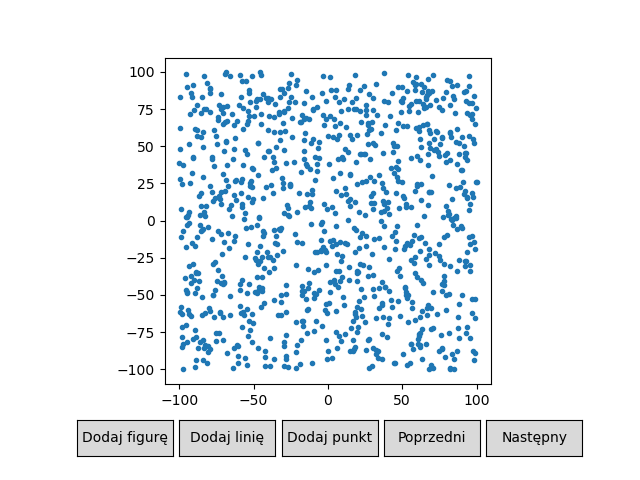

In [31]:
tab5 = generate_1(n=1000)
plot = Plot(points = [PointsCollection(tab5,marker = ".")])
plot.draw()

<IPython.core.display.Javascript object>


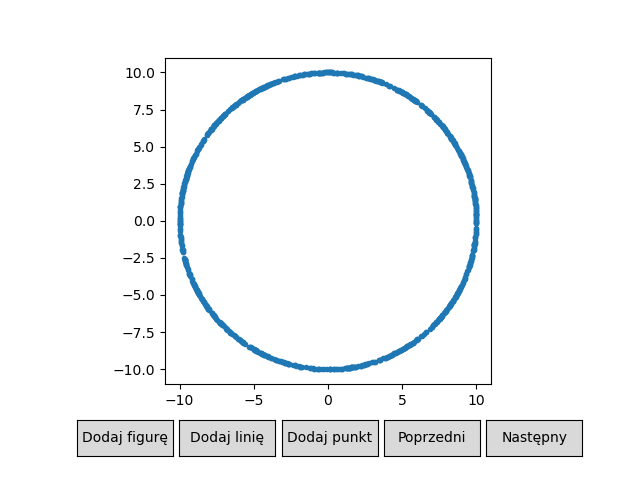

In [32]:
tab6 = generate_2(n=1000)
plot = Plot(points = [PointsCollection(tab6,marker = ".")])
plot.draw()

<IPython.core.display.Javascript object>


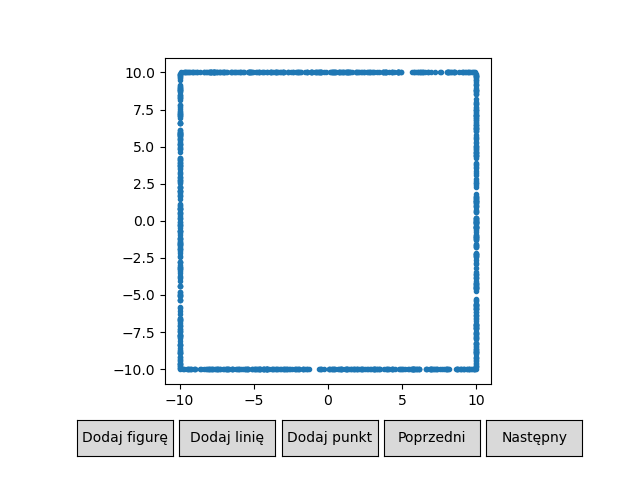

In [33]:
tab7 = generate_3(n=1000)
plot = Plot(points = [PointsCollection(tab7,marker = ".")])
plot.draw()

<IPython.core.display.Javascript object>


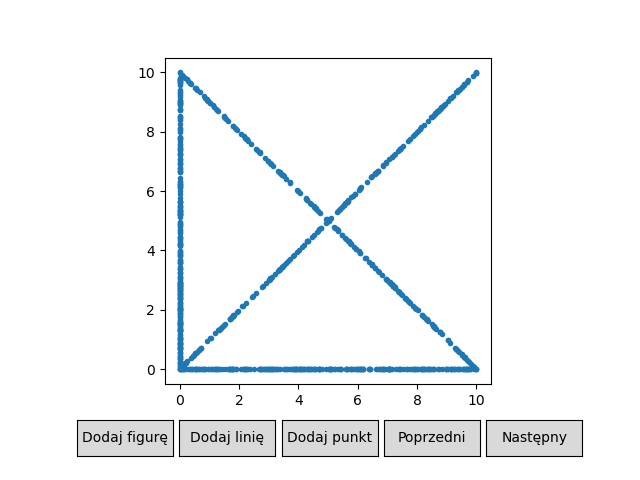

In [34]:
tab8 = generate_4(onaxis = 250, ondiagonal=200)
plot = Plot(points = [PointsCollection(tab8,marker = ".")])
plot.draw()

### GRAHAM

In [35]:
#algorytm grahama
def graham(points, e = 10**-12, sorting=axis_mergesort):
      
    T = sorting(points,lowest(points),e)
    
    n = len(T)
    stack = [0,1,2] #punkty należące do otoczki
    result = [T[0],T[1],T[2]]
    i = 3
    
            
    while i < n:
        if angle_compare(T[i],T[stack[-2]],T[stack[-1]],e) == -1:
            stack.append(i)
            result.append(T[i])
            i+=1
        else:
            stack.pop()
            result.pop() 
        
    
    return result    

### JARVIS

In [36]:
#algorytm jarvisa
def jarvis(points,e = 10**-12):
    n = len(points)
    low = lowest(points)
     
    hull = [low]
    result = [points[low]]
    while hull[-1] != low or len(hull) == 1:
        next_ind = (hull[-1]+1)%len(points)
        for j in range(n):
            if j != hull[-1] and angle_compare(points[j],points[next_ind],points[hull[-1]],e) == -1:
                next_ind = j
        if len(hull) > 1:
            if angle_compare(points[next_ind],points[hull[-1]],points[hull[-2]],e) == 0:
                hull.pop()
                result.pop()
        hull.append(next_ind)
        result.append(points[next_ind])
    result.pop()

    return result      

In [46]:
sets = [tab1,tab2,tab3,tab4,tab5,tab6,tab7,tab8]

Graham for set 1  with mergesort sort 0.012959718704223633 s
    Points in hull: 11
Graham for set 1  with built-in  sort 0.007944107055664062 s
    Points in hull: 11
Jarvis for set 1 0.010007381439208984 s
    Points in hull: 11

Graham for set 2  with mergesort sort 0.010969161987304688 s
    Points in hull: 100
Graham for set 2  with built-in  sort 0.006985902786254883 s
    Points in hull: 100
Jarvis for set 2 0.09079194068908691 s
    Points in hull: 100

Graham for set 3  with mergesort sort 0.009973287582397461 s
    Points in hull: 8
Graham for set 3  with built-in  sort 0.006981372833251953 s
    Points in hull: 8
Jarvis for set 3 0.016952991485595703 s
    Points in hull: 8

Graham for set 4  with mergesort sort 0.004987001419067383 s
    Points in hull: 4
Graham for set 4  with built-in  sort 0.004985332489013672 s
    Points in hull: 4
Jarvis for set 4 0.007978677749633789 s
    Points in hull: 4

Graham for set 5  with mergesort sort 0.1824791431427002 s
    Points in hul

<IPython.core.display.Javascript object>


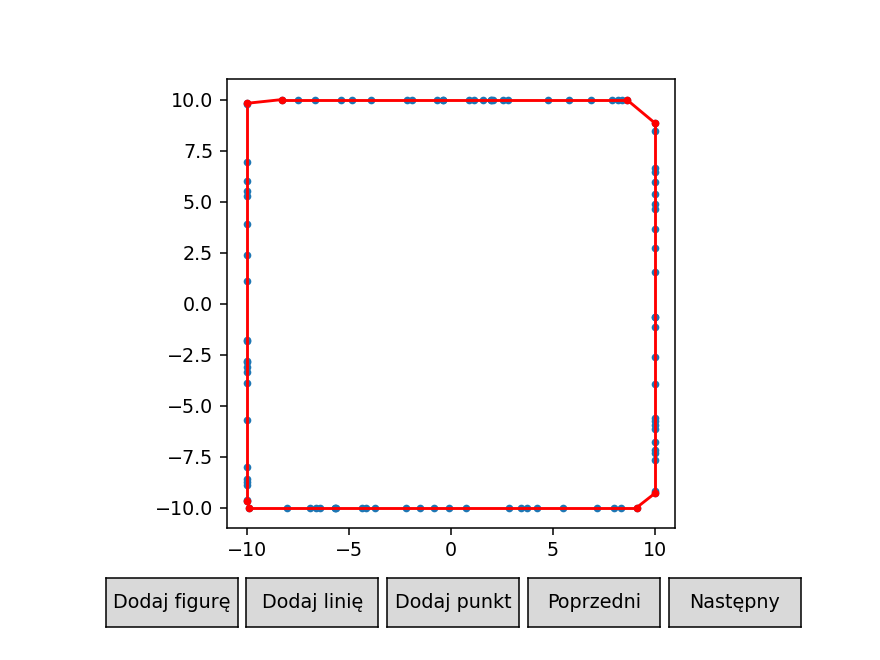

In [47]:
import time
e = 10**-12
scenes_s = []
counter = 1
for tab in sets:
    scenes_s.append(Scene([PointsCollection(tab,marker = ".")]))
    time_start = time.time()
    ghull = graham(tab,e,axis_mergesort)
    time_end = time.time()
    glines = []
    for i in range(len(ghull)):
        glines.append((ghull[i-1],ghull[i]))
    lines = [LinesCollection(glines,color = "yellow",)]
    points = [PointsCollection(tab,marker = "."), PointsCollection(ghull,color = "yellow",marker = ".")]
    scenes_s.append(Scene(points, lines))
    print("Graham for set", counter," with mergesort sort", time_end-time_start, "s")
    print("    Points in hull:", len(ghull))
    
    time_start = time.time()
    ghull = graham(tab,e,axis_sort)
    time_end = time.time()
    glines = []
    for i in range(len(ghull)):
        glines.append((ghull[i-1],ghull[i]))
    lines = [LinesCollection(glines,color = "red")]
    points = [PointsCollection(tab,marker = "."), PointsCollection(ghull,color = "red",marker = ".")]
    scenes_s.append(Scene(points, lines))
    print("Graham for set", counter," with built-in  sort", time_end-time_start, "s")
    print("    Points in hull:", len(ghull))
    
    
    time_start = time.time()
    jhull = jarvis(tab,e)
    time_end = time.time()
    jlines = []
    for i in range(len(jhull)):
        jlines.append((jhull[i-1],jhull[i]))
    lines = [LinesCollection(jlines,color = "green")]
    points = [PointsCollection(tab,marker = "."), PointsCollection(jhull,color = "green",marker = ".")]
    scenes_s.append(Scene(points,lines))
    print("Jarvis for set", counter, time_end-time_start, "s")
    print("    Points in hull:", len(jhull))
    
    counter += 1
    print()

plot = Plot(scenes=scenes_s)
plot.draw()

### GRAHAM - animacja

In [39]:
import copy
def graham_a(points, e = 10**-12, save = False):
    scenes = [Scene([PointsCollection(points,marker = ".")])]
    T = axis_sort(points,lowest(points),e)
    
    n = len(T)
    stack = [0,1,2] #punkty należące do otoczki
    result = [T[0],T[1],T[2]]
    i = 3
    
            
    while i < n:
        
        p= [ PointsCollection(points,marker = "."), PointsCollection(copy.copy(result), color = "red",marker = "."), PointsCollection([T[i]], color = "yellow",marker = ".") ]
        hull_lines_so_far = []
        for j in range(len(result)-1):
            hull_lines_so_far.append( (result[j],result[j+1]) )
        l= [ LinesCollection( hull_lines_so_far, color = "red" ), LinesCollection( [(T[i],result[-1],)], color = "yellow" )    ]
        scenes.append(Scene(points = p, lines = l))
        
        if angle_compare(T[i],T[stack[-2]],T[stack[-1]],e) == -1:
            stack.append(i)
            result.append(T[i])
            i+=1
        else:
            stack.pop()
            result.pop()
    
    
    p= [ PointsCollection(points,marker = "."), PointsCollection(copy.copy(result), color = "red",marker = ".") ]
    hull_lines_so_far = []
    for j in range(len(result)):
        hull_lines_so_far.append( (result[j-1],result[j]) )
    l= [ LinesCollection( hull_lines_so_far, color = "red" )    ]
    scenes.append(Scene(points = p, lines = l))
    
    if save == True:
        with open('graham.json', 'w+') as f:
            f.write(Plot(points = [PointsCollection(result)]).toJson())
    
    return scenes

In [40]:
def jarvis_a(points,e = 10**-12,save = False):
    scenes = [Scene([PointsCollection(points,marker = ".")])]
    
    n = len(points)
    low = lowest(points)
     
    hull = [low]
    result = [points[low]]
    while hull[-1] != low or len(hull) == 1:
        next_ind = (hull[-1]+1)%len(points)
        for j in range(n):
            if j != hull[-1] and angle_compare(points[j],points[next_ind],points[hull[-1]],e) == -1:
                next_ind = j
        if len(hull) > 1:
            if angle_compare(points[next_ind],points[hull[-1]],points[hull[-2]],e) == 0:
                hull.pop()
                result.pop()
        
        hull.append(next_ind)
        result.append(points[next_ind])
        p = [PointsCollection(points,marker = "."), PointsCollection(copy.copy(result), color = "red",marker = ".")]
        hull_lines_so_far = []
        for j in range(len(result)-1):
            hull_lines_so_far.append( (result[j],result[j+1]) )
        l = [LinesCollection(hull_lines_so_far, color = "red")]
        scenes.append(Scene(points = p, lines = l))
        
    if save == True:
        with open('jarvis.json', 'w+') as f:
            f.write(Plot(points = [PointsCollection(result)]).toJson())
    
    return scenes 

In [41]:
#analiza jak wpływa sposób sortowania. Numerowanie scen

<IPython.core.display.Javascript object>


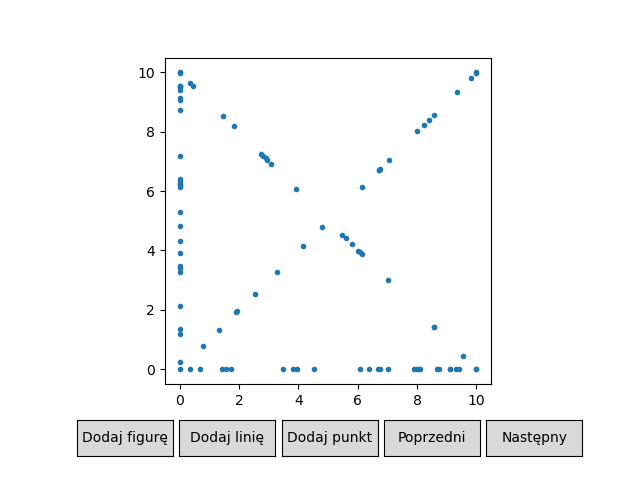

In [42]:
plot = Plot(scenes = graham_a(tab4,e))
plot.draw()

In [43]:
from PIL import Image, ImageDraw
def create_a_gif(hull_alg, points, name, save_to):
    plt.ioff()
    s = hull_alg(points)
    plot = Plot(scenes = s)
    for i in range(len(plot.scenes)):
        plot.save(i, path = save_to)
    images=[Image.open(save_to+'/figure_'+str(i)+'.png') for i in range(len(plot.scenes))]
    image = Image.new('RGB', (640, 480), (255, 255, 255))
    image.save(name, save_all=True, append_images=images,duration=200, loop=0)
    plt.ion()

sets = [tab1,tab2,tab3,tab4]
i = 1
for tab in sets:
    create_a_gif(graham_a,tab, 'graham_'+str(i)+'.gif' ,'figs')
    create_a_gif(jarvis_a,tab, 'jarvis_'+str(i)+'.gif','figs')
    i+=1